In [ ]:
!pip install texthero

In [44]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import texthero as hero
from texthero import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


In [28]:
cols = ['EventDescription', 'IncidentCause', 'IncidentConsequence', 'FailedAssets','Category']

In [29]:
df = pd.read_csv('/content/drive/MyDrive/ESV Data/cleaned_incidents1.csv', usecols = cols)
df = df.dropna()
df

,EventDescription,FailedAssets,IncidentCause,IncidentConsequence,Category
0,A nearby customer reported sparking of electri...,Conductor (ABC),HVABC cable faulted midspan,Grassfire,OH Cable
1,A contractor reported that he had contacted an...,No failed asset,Contractor contacted earthing conductor,No Go Zone (contact),Dug up
2,A field crew attending an outage found that a ...,Conductor (bare),Conductor broke due to rust,Serious risk to public safety (e.g. live condu...,Connection
3,Interfere and vandalism in substation. Unknown...,Indoor,Vandalism,Loss of supply;Damage to network assets,Other
4,A nearby customer reported that a high load ha...,Service conductor,Unknown high load contacted LV service cable,No Go Zone (contact);Damage to network assets,Vehicle
...,...,...,...,...,...
6499,A report came in to UE of a FMB sparking at 31...,Connection box,The likely cause was determined by EIO to be a...,Plant/equipment,Connection
6500,Report received from a resident to advise that...,Conductor (bare),Crane struck line,No Go Zone (contact);Damage to network assets,Vehicle
6501,Report received of pole fire at incident locat...,Pole (wood),Excessive leakage current,Pole-top fire,Pole
6502,A customer called to report a tractor had hit ...,Conductor (bare);Pole (wood),Farm equipment hit pole,Damage to network assets,Vehicle


In [30]:
df['description'] = df['EventDescription'] + ' ' + df['IncidentCause']+ ' ' + df['IncidentConsequence'] + ' ' + df['FailedAssets']

In [31]:
df['description']

0       A nearby customer reported sparking of electri...
1       A contractor reported that he had contacted an...
2       A field crew attending an outage found that a ...
3       Interfere and vandalism in substation. Unknown...
4       A nearby customer reported that a high load ha...
                              ...                        
6499    A report came in to UE of a FMB sparking at 31...
6500    Report received from a resident to advise that...
6501    Report received of pole fire at incident locat...
6502    A customer called to report a tractor had hit ...
6503    concrete electrical cover outside of front of ...
Name: description, Length: 6488, dtype: object

In [32]:
df['description'] = hero.clean(df['description'])

In [33]:
df['description']

0       nearby customer reported sparking electrical l...
1       contractor reported contacted earthing cable e...
2       field crew attending outage found 22kv conduct...
3       interfere vandalism substation unknown third p...
4       nearby customer reported high load pulled wire...
                              ...                        
6499    report came ue fmb sparking st kilda st bright...
6500    report received resident advise crane made con...
6501    report received pole fire incident location ar...
6502    customer called report tractor hit wire brough...
6503    concrete electrical cover outside front house ...
Name: description, Length: 6488, dtype: object

In [46]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1), min_df=10,use_idf= True) #using only unigrams for tfidf
tf_idf_vect.fit(df['description'])
#print(tf_idf_vect.get_feature_names()[0:10])
final_tf_idf = tf_idf_vect.transform(df['description'])

Number of components = 4 and explained variance = 0.09541597636258328
Number of components = 10 and explained variance = 0.18149785975126298
Number of components = 15 and explained variance = 0.2205098295711846
Number of components = 20 and explained variance = 0.25104496590633324
Number of components = 50 and explained variance = 0.3630293042793724
Number of components = 100 and explained variance = 0.46818124648189824
Number of components = 150 and explained variance = 0.541734374903447
Number of components = 200 and explained variance = 0.5983008058502745
Number of components = 500 and explained variance = 0.7927599178721246
Number of components = 700 and explained variance = 0.8622636942670716
Number of components = 800 and explained variance = 0.8882819261694628
Number of components = 900 and explained variance = 0.9100847376019349
Number of components = 1000 and explained variance = 0.9284545943701951
Number of components = 1500 and explained variance = 0.9839559129383032


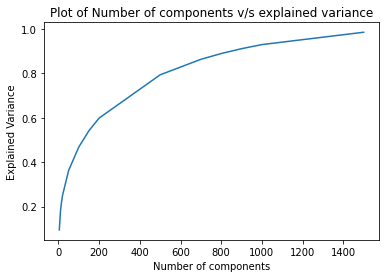

In [35]:
n_comp = [4,10,15,20,50,100,150,200,500,700,800,900,1000,1500] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(final_tf_idf)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [ ]:
#1500 features can explain 98% of the dataset

In [36]:
svd = TruncatedSVD(n_components=1500, random_state=42)
#svd.fit(final_tf_idf)

In [37]:
final = svd.fit_transform(final_tf_idf)

In [38]:
print(final)

[[ 1.91766360e-01 -3.40513295e-02 -2.29923382e-02 ...  1.03404174e-02
   7.41971242e-03 -2.47204125e-03]
 [ 2.41963936e-01 -1.71161578e-01 -1.63754989e-01 ...  1.87038972e-02
  -2.56953497e-03  5.34012393e-03]
 [ 2.72818577e-01 -1.13731037e-01 -6.80982499e-02 ...  5.58666500e-04
   5.69063051e-03  1.28606297e-02]
 ...
 [ 6.35686914e-01  3.96146463e-01  6.14668447e-02 ...  1.02488036e-05
  -6.26058795e-03  9.61062527e-04]
 [ 2.66720862e-01 -2.06508341e-02 -2.10227414e-02 ...  5.50412401e-03
  -6.99502411e-03 -5.75876489e-03]
 [ 7.43355794e-02 -1.31308769e-01  9.26146432e-02 ... -4.04086154e-03
   5.73427134e-03 -6.44264452e-03]]


In [39]:
final.shape

(6488, 1500)

In [40]:
le = LabelEncoder()
Y = le.fit_transform(df['Category'])

array([ 9,  5,  3, ..., 11, 14,  0])

In [41]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final,Y, 
                                                    test_size=0.25, random_state=4, stratify = Y)

In [45]:
svc = SVC(C=1.0, kernel = 'linear', probability = True)
svc.fit(x_train, y_train)
accuracy = accuracy_score(y_test,svc.predict(x_test))
print(accuracy)

0.8360049321824907
